In [1]:
import subprocess

subprocess.check_call(["python3", '-m', 'pip', 'install', 'dgl'])
# import dgl-cu101
# import dgl-cu11 as dg
import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
!pip install dgl-cu110 

In [10]:
!pip uninstall dgl

In [ ]:
!nvcc --version

In [2]:
import os
import dgl.data
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import tqdm
from sklearn.linear_model import LinearRegression

In [3]:
os.chdir("/content/drive/MyDrive/Winter_Research")

## Make the Dataset

#### Load into RAM

In [4]:
master_df = pd.read_csv("Sentinel2_Traffic/Traffic_Data/5_state_traffic.csv")
master_df = master_df.set_index("Unnamed: 0")
CA_x, CA_y = [], []
KS_x, KS_y = [], []
MT_x, MT_y = [], []
TX_x, TX_y = [], []
OH_x, OH_y = [], []
states = {"CA" : [CA_x, CA_y, "Roi_1"],
         "KS" : [KS_x, KS_y, "Roi_2"],
         "MT" : [MT_x, MT_y, "Roi_3"],
         "TX" : [TX_x, TX_y, "Roi_4"],
         "OH" : [OH_x, OH_y, "Roi_5"]}
# for st in ["CA", "KS", "MT", "TX", "OH"]:
for st in ["CA"]:
  path_check = "Rois/" + states[st][2] + "/greedy_a/"
  path = "Rois/" + states[st][2] + "/sent_cloud_90p_raw/"
  imgs_check = os.listdir(path_check)
  imgs = os.listdir(path)
  for img, img_check in zip(imgs, imgs_check):
    date = img.split('.')[0]
    photo = np.loadtxt(path + img).reshape(-1, 5)
    photo_check = np.loadtxt(path_check + img_check).reshape(-1, 7, 3)
    if photo_check[pd.isnull(photo_check)].shape[0] == 0:
      if date in list(master_df.index):
        if not pd.isna(master_df.loc[date][st]):
          states[st][0].append(photo)
          states[st][1].append(master_df.loc[date][st])

In [8]:
device = torch.cuda.current_device()

In [5]:
def gen_around(x, y):
  return [(x, y), (x, y + 10), (x, y - 10), (x + 10, y), (x - 10, y), (x + 10, y + 10), (x + 10, y - 10), (x - 10, y + 10), (x - 10, y - 10)]

def gen_around_strict(x, y):
  return [(x, y), (x, y + 10), (x, y - 10), (x + 10, y), (x - 10, y)]

def neighbors(road, coords, x, y, diagonal=True):
  neigh = []
  if diagonal:
    cand = gen_around(x, y)
  else:
    cand = gen_around_strict(x, y)
  for pix in cand:
    if pix[0] in coords:
      if pix[1] in coords[pix[0]]:
        neigh.append(coords[pix[0]][pix[1]]['idx'])
  return neigh

def src_dst(road, coords, diagonal=True):
  src, dst, values = [],  [] , []
  for row in range(road.shape[0]):
    x = road[row][4]
    y = road[row][3]
    idx = coords[x][y]['idx']
    val = coords[x][y]['val']
    if val[0] != road[row][:3][0]:
      assert(False)
    for c in neighbors(road, coords, x, y, diagonal):
      src.append(idx)
      dst.append(c)
      values.append(val)
  return src, dst #, values

In [ ]:
gdl.data.save_graphs(Road_Graphs, "Rois")

In [ ]:
type(Road_Graphs)

In [6]:
class RoadDataset(DGLDataset):
  def __init__(self, states):
    self.states = states
    super().__init__(name='road_graphs')

  def process(self):
    self.graphs = []
    self.labels = []
    self.state = []
    # for st in self.states.keys():
    for st in ["CA"]:
      print(st)
      for i in range(len(self.states[st][0])):
        print(i)
        img = states[st][0][i]
        coords = {}
        vals = []
        for j in range(img.shape[0]):
          # print(img[j].shape)
          lon = img[j][4].astype(int)
          # print(lon)
          lat = img[j][3].astype(int)
          val = img[j][:3]
          vals.append(val)
          if lon not in coords:
            coords[lon] = {}
          coords[lon][lat] = {'idx' : j, 'val' : val}
        src, dst = src_dst(img, coords)
        #src, dst, values = src_dst(img, coords)
        # print(np.mean(src), np.mean(dst), np.mean(values))
        graph = dgl.graph((src, dst), num_nodes=img.shape[0])
        graph.ndata['feat'] = torch.from_numpy(np.array(vals))
        #graph = graph.add_self_loop(graph)
        # graph = graph.to(device)
        self.graphs.append(graph)
        self.labels.append(self.states[st][1][i])
        self.state.append(st)
        # assert(False)

  def __getitem__(self, i):
      return self.graphs[i], self.labels[i]

  def __len__(self):
      return len(self.graphs)


In [ ]:
Road_Graphs = RoadDataset(states)

In [15]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
# dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)
dataset = Road_Graphs

In [ ]:
print('Node feature dimensionality:', 3)#Road_Graphs.dim_nfeats)
print('Number of graph categories:', dataset.gclasses)

Node feature dimensionality: 3
Number of graph categories: 2


In [8]:
dataset = Road_Graphs

## Train the Model

In [9]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [10]:
num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [11]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=361320, num_edges=2937840,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={}), tensor([2034., 2404., 3612., 2444., 2786.], dtype=torch.float64)]


In [12]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([72264, 72264, 72264, 72264, 72264])
Number of edges for each graph element in the batch: tensor([587568, 587568, 587568, 587568, 587568])
The original graphs in the minibatch:
[Graph(num_nodes=72264, num_edges=587568,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={}), Graph(num_nodes=72264, num_edges=587568,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={}), Graph(num_nodes=72264, num_edges=587568,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={}), Graph(num_nodes=72264, num_edges=587568,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={}), Graph(num_nodes=72264, num_edges=587568,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={})]


In [22]:
from dgl.nn import GraphConv, DenseGraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h1_feats, h2_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h1_feats)
        self.conv2 = GraphConv(h1_feats, h2_feats)
        self.conv3 = GraphConv(h2_feats, num_classes)
        # self.linear1 = nn.Linear(in_features=lin1, out_features=lin2)
        # self.linear2 = nn.Linear(in_features=lin2, out_features=lin3)
        # self.linear3 = nn.Linear(in_features=lin3, out_features=num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.conv3(g, h)
        # print(type(h))
        # print(h.shape)
        # h = h.reshape(-1, 10)
        # h = self.linear1(h)
        # h = F.relu(h)
        # h = self.linear2(h)
        # h = F.relu(h)
        # h = self.linear3(h)
        g.ndata['h'] = h
        # print(dgl.mean_nodes(g, 'h'))
        # assert(False)
        return dgl.mean_nodes(g, 'h')

In [23]:
# device = torch.cuda.current_device()

In [42]:
# Create the model with given dimensions
model = GCN(3, 100, 100, 1) # 10, 100, 50, 1)
# model = GCN(3, 16, 1)
# model.cuda()
criterion = nn.MSELoss()
#model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
  loss_tot = 0
  batches = 0
  for batched_graph, labels in train_dataloader:
    # batched_graph.to(device)
    # labels.to(device)
    pred = model(batched_graph, batched_graph.ndata['feat'].float()) 
    # print(pred, labels)
    loss = criterion(pred, labels.reshape(labels.shape[0], 1).float())
    loss_tot += loss.item()
    batches += 1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(loss_tot / batches)

# num_correct = 0
# num_tests = 0




2344885.5680803573
566424.3571428572
555550.5714285715
596101.515625
528546.375
478390.53125
423739.046875
401977.43610491074
415582.80803571426
462311.01116071426


In [43]:
x = []
y = []
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['feat'].float())
    loss += criterion(pred, labels.reshape(labels.shape[0], 1).float()).item()
    x.extend([x[0] for x in pred.detach().numpy().tolist()])
    y.extend([x[0] for x in labels.reshape(labels.shape[0], 1).detach().numpy().tolist()])
    num_tests += 1
print('Test loss:', loss / num_tests)

Test loss: tensor(828732.8750, grad_fn=<DivBackward0>)


In [ ]:
batched_graph

Graph(num_nodes=1428504, num_edges=11581332,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={})

In [ ]:
labels

tensor([3612., 2207., 1657.,  859.,  290.,  700., 2589., 2047., 1242., 1049.,
         253., 1769.,  819.,  376.,  583., 2998.,  801.,  723.,  320.,  641.],
       dtype=torch.float64)

In [ ]:
[x[0] for x in pred.detach().numpy().tolist()]

[1090.12109375, 898.9130249023438, 984.0169067382812]

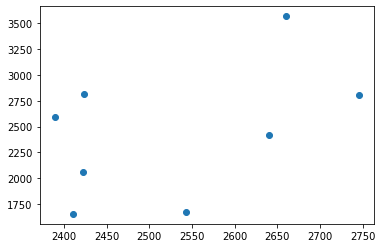

In [44]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

In [37]:
x_temp = y
y_temp = x

In [19]:
for i in range(len(y_temp)):
  if y_temp[i] > 1200:
    print(len(x_temp))
    x_temp.pop(i)
    y_temp.pop(i)
    i = i - 1
    break

8


0.21250209289307698


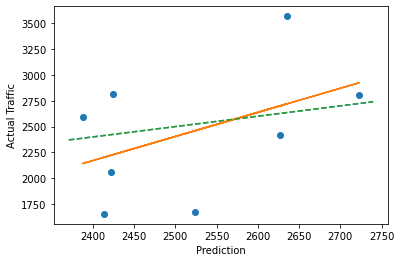

In [45]:
# print(y_temp)

x_plot = np.array(y_temp)
y_plot = np.array(x_temp)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
pre_y = fit.predict(new_x)
# plt.plot
plt.plot(new_x, pre_y)
plt.plot(x_vals, y_vals, '--')
# plt.savefig("Just_GCN_Cali_fit.png")
plt.show()

In [ ]:
›y

[646.0,
 530.0,
 590.0,
 865.0,
 592.0,
 895.0,
 475.0,
 745.0,
 866.0,
 646.0,
 593.0,
 809.0,
 934.0,
 767.0,
 539.0,
 480.0,
 623.0,
 459.0,
 608.0,
 728.0,
 799.0,
 909.0,
 766.0,
 462.0,
 412.0,
 571.0,
 676.0,
 475.0]

In [ ]:
labels

tensor([0, 0, 0, 1, 0])